衝突は単視点の情報では捉えづらいのでは？
・見る視点によってどのくらい近づけば衝突するか分からないから

In [1]:
# !pip install pybullet
# !pip install imageio==2.4.1
# # いろいろなURDFのサンプルが入っています
# !git clone https://github.com/bulletphysics/bullet3.git

import pybullet as p
import time
import pybullet_data
import pandas as pd
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from base64 import b64encode
from IPython.display import HTML
import numpy as np
from google.colab import files
import uuid, shutil

def save_video(frames, path):
    clip = mpy.ImageSequenceClip(frames, fps=30)
    clip.write_videofile(path, fps=30)

def play_mp4(path):
    mp4 = open(path, 'rb').read()
    url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % url)


WIDTH = 100
HEIGHT = 100
DELTA_TIME = 1. / 240

In [2]:
# ローカルで実行する場合はp.GUIを指定することでOpenGLなどを利用できます
physicsClient = p.connect(p.DIRECT)

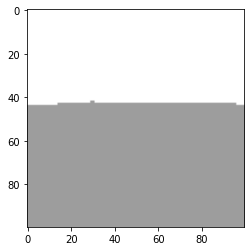

In [3]:
# 床を出現させます
def get_plane(reset=False, show=False, g=-10):
    if reset:
        # 全オブジェクトを消し，worldを初期状態に戻します
        p.resetSimulation()

    # 重力
    p.setGravity(0, 0, g)

    # デフォルトと同じ240Hz．変えない方が良い
    timestep = 1. / 240.
    p.setTimeStep(timestep)

    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    planeId = p.loadURDF("plane.urdf")
    # カメラを設定し画像を取得
    if show:
        _, _, rgbImg, depthImg, segImg = p.getCameraImage(WIDTH, HEIGHT)
        plt.imshow(rgbImg); plt.show()

get_plane(reset=True, show=True)

In [4]:
def get_view_and_projection(
    cameraTargetPosition,
    distance,
    yaw,
    pitch,
    roll,
    fov,
    upAxisIndex=2,
    nearVal=0.01,
    farVal=100,
    ):

    view_mat = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition, distance, yaw, pitch, roll, upAxisIndex
    )

    aspect = WIDTH / HEIGHT
    proj_mat = p.computeProjectionMatrixFOV(
        fov, aspect, nearVal, farVal
    )

    return view_mat, proj_mat

In [5]:
fov = 20
camera_distance = 5
focal = 1/np.tan(fov*0.5)

cam_config = get_view_and_projection(
        cameraTargetPosition=[0, 0, 0.5],
        distance=camera_distance,
        yaw=45,
        pitch=-10,
        roll = 0,
        fov = fov
    )

In [6]:
def reset_sim(show=False):
    get_plane(reset=True, g=-1)
    
    cubeStartPos2 = [0,0,1.0]
    cubeStartOrientation = p.getQuaternionFromEuler([0.78,0.78,0]) # ここを変える
    greenBlockId2 = p.loadURDF("block.urdf",cubeStartPos2, cubeStartOrientation, globalScaling=5)

    if show:
        _, _, rgbImg, depthImg, segImg = p.getCameraImage(WIDTH, HEIGHT, *cam_config)
        plt.imshow(rgbImg); plt.show()

    return greenBlockId2

In [7]:
# 普通のやつ
_ = reset_sim()

frames = []
for t in range(1200):
    p.stepSimulation()
    
    if t % 16 == 0:
        _, _, rgbImg, _, _ = p.getCameraImage(WIDTH, HEIGHT, *cam_config) # 4つ目にalphaが入る
        frames.append(rgbImg[:,:,:3])

save_video(frames, "sample.mp4")
play_mp4("sample.mp4")

[MoviePy] >>>> Building video sample.mp4
[MoviePy] Writing video sample.mp4


100%|██████████| 76/76 [00:00<00:00, 1462.41it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: sample.mp4 



In [8]:
poses = []
images = []

_ = reset_sim()

num_view = 800
yaw_per_view = 360/num_view
pitch_per_view = - 80/num_view

cam_configs = []

for i in range(num_view):
    cam_config = get_view_and_projection(
            cameraTargetPosition=[0, 0, 0.5],
            distance=camera_distance,
            yaw=yaw_per_view*i,
            pitch=-10 + pitch_per_view*i,
            roll = 0,
            fov = fov
    )
    cam_configs.append(cam_config)
    poses.append(cam_config[0])



for t in range(1200):
    p.stepSimulation()
    
    if t % 32 == 0:
        frames = []
        for cam_config in cam_configs:
            _, _, rgbImg, _, _ = p.getCameraImage(WIDTH, HEIGHT, *cam_config) # 4つ目にalphaが入る
            frames.append(rgbImg[:,:,:3])
        images.append(frames)

In [9]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [10]:
# 20視点、100フレーム、100回
np.savez(
        f"test.npz",
        images=images,
        poses=poses,
        focal=focal,
        cam_dist=camera_distance,
    )

In [13]:
data_f = "test.npz"
data = np.load(data_f)
data.files

['images', 'poses', 'focal', 'cam_dist']

In [14]:
data['poses'].shape

(23, 16)